DD

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# ---------------------------------------------------------
# 1. Device Configuration
# ---------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print("PyTorch version:", torch.__version__)
print("Device:", device)

# ---------------------------------------------------------
# 2. Dataset Paths Configuration
# ---------------------------------------------------------
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4  # Adjust based on your system

# Training Data - Using Public_dataset (raw)
PUBLIC_DATASET = r"../Dataset/Public_dataset"

# Evaluation Dataset - Using SelfCollected_Dataset (raw)
SELF_COLLECTED_DATASET = r"../Dataset/SelfCollected_Dataset"

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✓ Paths configured successfully")
print(f"\nTraining on: {PUBLIC_DATASET}")
print(f"Evaluation on: {SELF_COLLECTED_DATASET}")


Using CUDA GPU: NVIDIA GeForce RTX 3050 Laptop GPU
PyTorch version: 2.5.1+cu121
Device: cuda
✓ Paths configured successfully

Training on: ../Dataset/preprocessed_Public/train
Validation on: ../Dataset/preprocessed_Public/val
Test on preprocessed_Public: ../Dataset/preprocessed_Public/test
Test Dataset 1 (Preprocessed Self): ../Dataset/preprocessed_self/test
Test Dataset 2 (Raw Self-Collected): ../Dataset/SelfCollected_Dataset


In [ ]:
# ---------------------------------------------------------
# 3. Data Transforms Setup
# ---------------------------------------------------------
from torch.utils.data import random_split

# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Data transforms defined")

# ---------------------------------------------------------
# 4. DataLoader Creation Function (with train/val split)
# ---------------------------------------------------------
def create_dataloaders(data_path, train_split=0.8):
    """
    Create PyTorch DataLoaders for training and validation with split
    Args:
        data_path: Path to dataset folder (containing class subfolders)
        train_split: Ratio of data to use for training (default 0.8 = 80%)
    """
    print(f"\nLoading dataset from: {data_path}")
    
    # Load full dataset
    full_dataset = datasets.ImageFolder(data_path, transform=train_transform)
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    # Split dataset
    train_dataset, val_dataset_temp = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create validation dataset with val_test_transform
    val_dataset = datasets.ImageFolder(data_path, transform=val_test_transform)
    val_indices = val_dataset_temp.indices
    val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"\nDataset sizes:")
    print(f"  Total:      {total_size} images")
    print(f"  Training:   {train_size} images ({train_split*100:.0f}%)")
    print(f"  Validation: {val_size} images ({(1-train_split)*100:.0f}%)")
    print(f"  Classes: {full_dataset.classes}")
    
    return train_loader, val_loader

def create_test_loader(test_path, dataset_name="Test"):
    """
    Create PyTorch DataLoader for testing
    """
    test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"\n{dataset_name} Dataset:")
    print(f"  Total images: {len(test_dataset)}")
    print(f"  Classes: {test_dataset.classes}")
    
    return test_loader

print("✓ DataLoader functions defined")


✓ Data transforms defined
✓ DataLoader functions defined


In [4]:
# ---------------------------------------------------------
# 5. Model Architecture (ResNet50)
# ---------------------------------------------------------
def build_resnet50_model():
    """
    Build ResNet50 model with custom classification head
    """
    print("Building ResNet50 Model...")
    
    # Load pretrained ResNet50
    weights = ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)
    
    # Get the number of input features
    num_features = model.fc.in_features
    
    # Replace fc with custom head
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    
    model = model.to(device)
    return model

print("✓ ResNet50 architecture function defined")

✓ ResNet50 architecture function defined


In [13]:
# ---------------------------------------------------------
# 6. Training Function
# ---------------------------------------------------------
def train_model(model, train_loader, val_loader, model_name, epochs=30):
    """
    Train the PyTorch model
    """
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    patience_limit = 10
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]  ')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        # Learning rate scheduler
        scheduler.step(epoch_val_loss)
        
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'{model_name}.pth')
            print(f"  ✓ Best model saved (Val Acc: {best_val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience_limit:
            print(f"\n  Early stopping triggered after {epoch+1} epochs")
            break
        
        print()
    
    # Load best model
    model.load_state_dict(torch.load(f'{model_name}.pth'))
    print(f"\n✓ Training completed. Best Val Acc: {best_val_acc:.4f}")
    
    return history

print("✓ Training function defined")

✓ Training function defined


In [14]:
# ---------------------------------------------------------
# 7. Evaluation Function
# ---------------------------------------------------------
def evaluate_model(model, test_loader, experiment_name):
    """
    Evaluate model and display results
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [ ]:
# ---------------------------------------------------------
# 8. Create DataLoaders for Training and Validation
# ---------------------------------------------------------
# Using Public_dataset with 80/20 train/val split
train_loader, val_loader = create_dataloaders(
    PUBLIC_DATASET, 
    train_split=0.8  # 80% training, 20% validation
)



Dataset sizes:
  Training:   7512 images
  Validation: 403 images
  Testing:    533 images
  Classes: ['aluminium', 'paper', 'plastic']


In [15]:
# ---------------------------------------------------------
# 9. Build Model
# ---------------------------------------------------------
resnet_model = build_resnet50_model()

Building ResNet50 Model...


In [ ]:
# ---------------------------------------------------------
# 10. Train Model
# ---------------------------------------------------------
history = train_model(
    resnet_model, 
    train_loader, 
    val_loader, 
    model_name='resnet50_waste_clf_raw', 
    epochs=30
)



Training resnet50_waste_clf



Epoch 1/30 [Val]  : 100%|██████████| 13/13 [00:02<00:00,  5.52it/s, loss=0.0648, acc=95.04%]



Epoch 1/30:
  Train Loss: 0.2508, Train Acc: 0.9059
  Val Loss:   0.1644, Val Acc:   0.9504
  ✓ Best model saved (Val Acc: 0.9504)



Epoch 2/30 [Val]  : 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, loss=0.0078, acc=96.77%]



Epoch 2/30:
  Train Loss: 0.0374, Train Acc: 0.9896
  Val Loss:   0.1077, Val Acc:   0.9677
  ✓ Best model saved (Val Acc: 0.9677)



Epoch 3/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  9.71it/s, loss=0.0917, acc=97.27%]



Epoch 3/30:
  Train Loss: 0.0388, Train Acc: 0.9875
  Val Loss:   0.0934, Val Acc:   0.9727
  ✓ Best model saved (Val Acc: 0.9727)



Epoch 4/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.01it/s, loss=0.0518, acc=96.28%]



Epoch 4/30:
  Train Loss: 0.0234, Train Acc: 0.9916
  Val Loss:   0.1524, Val Acc:   0.9628



Epoch 5/30 [Val]  : 100%|██████████| 13/13 [00:02<00:00,  6.15it/s, loss=0.1205, acc=95.78%]



Epoch 5/30:
  Train Loss: 0.0115, Train Acc: 0.9965
  Val Loss:   0.1720, Val Acc:   0.9578



Epoch 6/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  6.86it/s, loss=0.0073, acc=97.52%]



Epoch 6/30:
  Train Loss: 0.0192, Train Acc: 0.9941
  Val Loss:   0.1042, Val Acc:   0.9752
  ✓ Best model saved (Val Acc: 0.9752)



Epoch 7/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.19it/s, loss=0.0448, acc=98.01%]



Epoch 7/30:
  Train Loss: 0.0141, Train Acc: 0.9965
  Val Loss:   0.1018, Val Acc:   0.9801
  ✓ Best model saved (Val Acc: 0.9801)



Epoch 8/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  6.88it/s, loss=0.0050, acc=97.27%]



Epoch 8/30:
  Train Loss: 0.0066, Train Acc: 0.9985
  Val Loss:   0.1263, Val Acc:   0.9727



Epoch 9/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.23it/s, loss=0.0223, acc=96.03%]



Epoch 9/30:
  Train Loss: 0.0122, Train Acc: 0.9961
  Val Loss:   0.1797, Val Acc:   0.9603



Epoch 10/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00, 10.69it/s, loss=0.0479, acc=96.03%]



Epoch 10/30:
  Train Loss: 0.0046, Train Acc: 0.9984
  Val Loss:   0.1999, Val Acc:   0.9603



Epoch 11/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.04it/s, loss=0.0036, acc=97.02%]



Epoch 11/30:
  Train Loss: 0.0069, Train Acc: 0.9985
  Val Loss:   0.1838, Val Acc:   0.9702



Epoch 12/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.12it/s, loss=0.0040, acc=97.02%]



Epoch 12/30:
  Train Loss: 0.0047, Train Acc: 0.9993
  Val Loss:   0.1655, Val Acc:   0.9702



Epoch 13/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.16it/s, loss=0.0058, acc=96.77%]



Epoch 13/30:
  Train Loss: 0.0020, Train Acc: 0.9995
  Val Loss:   0.1699, Val Acc:   0.9677



Epoch 14/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.12it/s, loss=0.0758, acc=96.77%]



Epoch 14/30:
  Train Loss: 0.0037, Train Acc: 0.9991
  Val Loss:   0.1835, Val Acc:   0.9677



Epoch 15/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.28it/s, loss=0.0008, acc=97.27%]



Epoch 15/30:
  Train Loss: 0.0033, Train Acc: 0.9993
  Val Loss:   0.1522, Val Acc:   0.9727



Epoch 16/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  7.28it/s, loss=0.0012, acc=97.02%]



Epoch 16/30:
  Train Loss: 0.0010, Train Acc: 0.9997
  Val Loss:   0.1470, Val Acc:   0.9702



Epoch 17/30 [Val]  : 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, loss=0.0065, acc=97.02%]
/tmp/ipykernel_112534/807130263.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat


Epoch 17/30:
  Train Loss: 0.0010, Train Acc: 0.9995
  Val Loss:   0.1571, Val Acc:   0.9702

  Early stopping triggered after 17 epochs

✓ Training completed. Best Val Acc: 0.9801



EVALUATION ON TEST DATASET 1: PREPROCESSED SELF-COLLECTED

Test Dataset 1 (Preprocessed Self) Dataset:
  Total images: 533
  Classes: ['aluminium', 'paper', 'plastic']

Evaluating: ResNet50 - Preprocessed Self-Collected Test



Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Testing: 100%|██████████| 17/17 [00:03<00:00,  5.66it/s]



Classification Report:
              precision    recall  f1-score   support

   aluminium       0.25      0.49      0.33       148
       paper       0.20      0.11      0.14       151
     plastic       0.44      0.29      0.35       234

    accuracy                           0.29       533
   macro avg       0.30      0.30      0.27       533
weighted avg       0.32      0.29      0.28       533



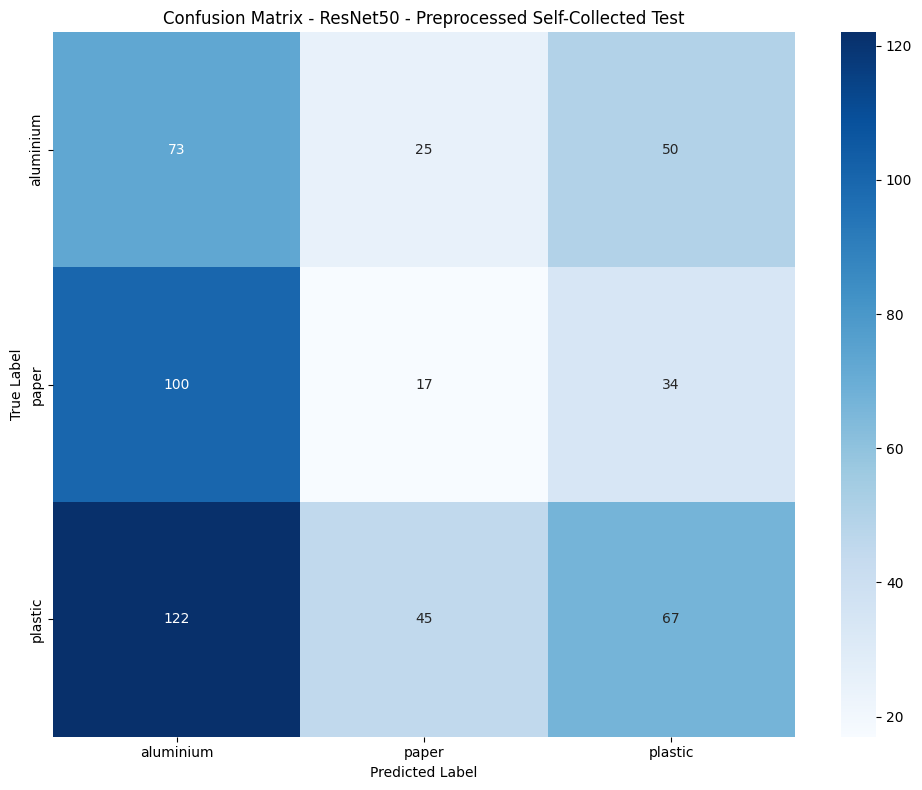


Results Summary - ResNet50 - Preprocessed Self-Collected Test
Test Loss:      1.1020
Test Accuracy:  0.2946
Precision:      0.3189
Recall:         0.2946
F1-Score:       0.2848



In [ ]:
# ---------------------------------------------------------
# 11. Evaluate Model on Test Dataset (Self-Collected)
# ---------------------------------------------------------
print("\n" + "="*80)
print("EVALUATION ON SELF-COLLECTED DATASET")
print("="*80)

test_loader = create_test_loader(SELF_COLLECTED_DATASET, "Self-Collected Test Dataset")
results = evaluate_model(
    resnet_model, 
    test_loader, 
    experiment_name="ResNet50 - Self-Collected Dataset Evaluation"
)


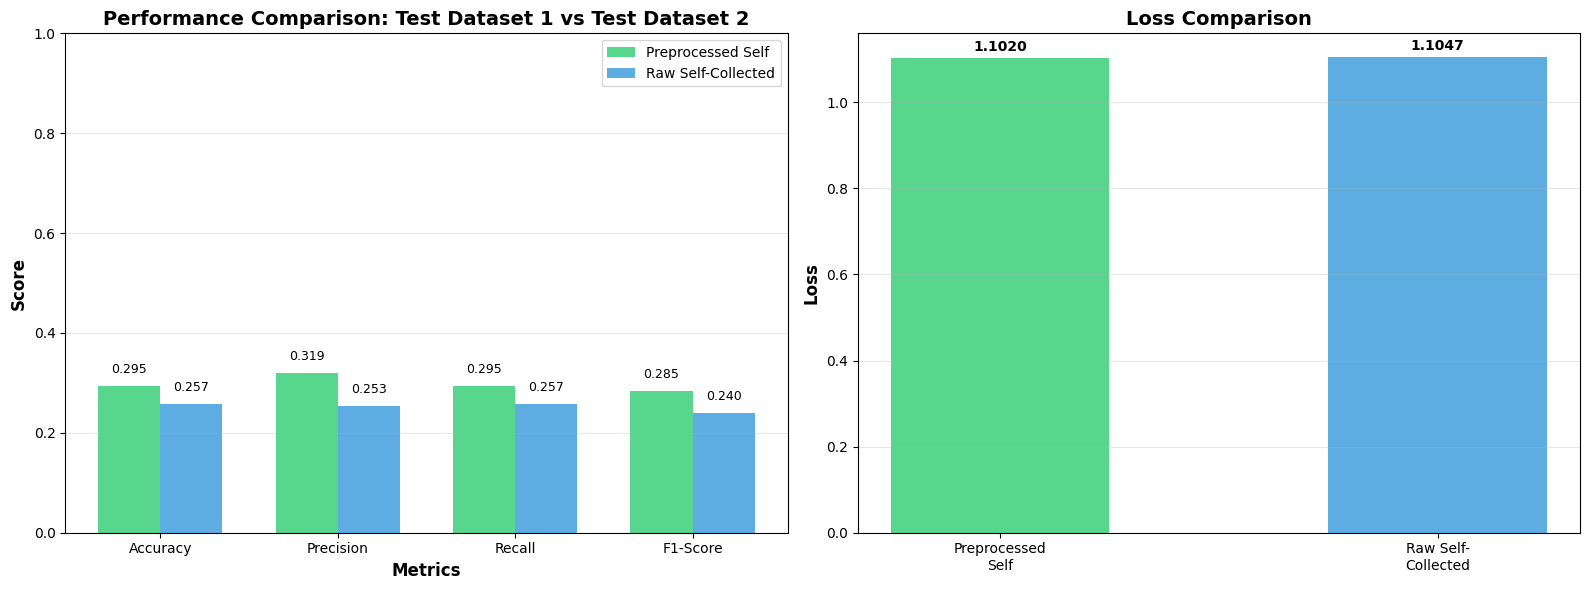

In [ ]:
# ---------------------------------------------------------
# 12. Visualize Results
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [results['accuracy'], results['precision'], results['recall'], results['f1']]

# Bar chart
axes[0].bar(metrics, values, color='#3498db', alpha=0.8)
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance on Self-Collected Dataset', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for i, v in enumerate(values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Loss visualization
axes[1].bar(['Loss'], [results['loss']], color='#e74c3c', alpha=0.8, width=0.5)
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0, results['loss'] + 0.01, f'{results["loss"]:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------------------------------------
# 13. Save Results to CSV
# ---------------------------------------------------------
# Save evaluation results
results_summary = pd.DataFrame({
    'Dataset': ['Self-Collected Dataset'],
    'Accuracy': [results['accuracy']],
    'Precision': [results['precision']],
    'Recall': [results['recall']],
    'F1-Score': [results['f1']],
    'Loss': [results['loss']]
})

# Save to CSV
output_file = 'results/resnet50_evaluation_results.csv'
results_summary.to_csv(output_file, index=False)
print(f"\n✓ Evaluation results saved to: {output_file}")
print("\nFinal Results Summary:")
print(results_summary.to_string(index=False))


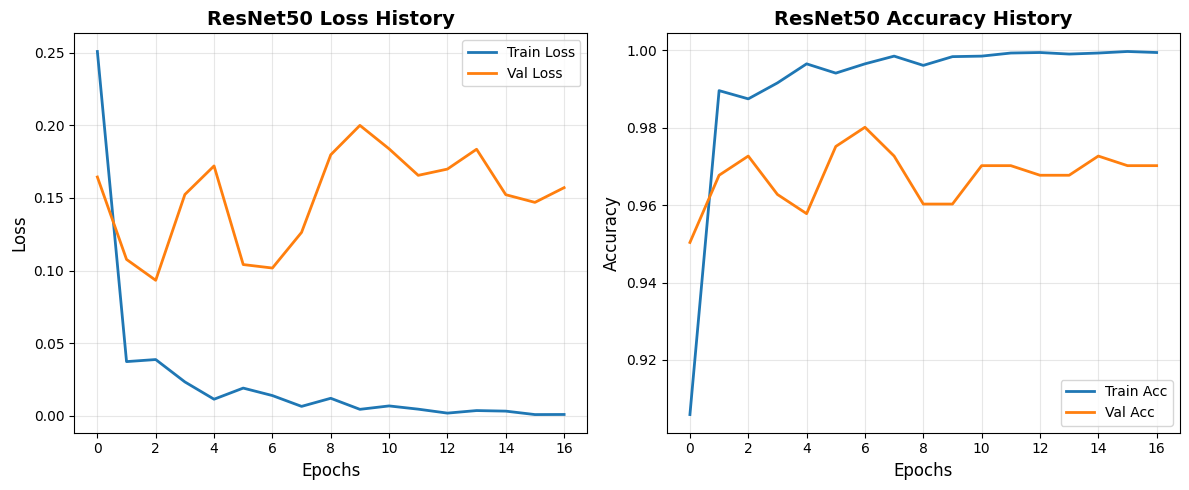

✓ Training history plot saved to: results/resnet50_training_history.png


In [ ]:
# ---------------------------------------------------------
# 14. Plot Training History
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.title('ResNet50 Loss History (Public Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', linewidth=2)
plt.plot(history['val_acc'], label='Val Acc', linewidth=2)
plt.title('ResNet50 Accuracy History (Public Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/resnet50_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to results/resnet50_training_history.png")
